In [44]:
from google.colab import drive
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
drive.mount('/content/gdrive')
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import datetime
import torch
import torch.nn.functional as F
from numpy import dot 
from numpy.linalg import norm

#1-1

meta = pd.read_csv( './ratings.csv' )
x = meta
x_train, x_test = train_test_split(x, test_size=0.2, shuffle=True, random_state=42)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [45]:
# 1-2
meta_mv = pd.read_csv( './movies.csv' )

i = 0
for genre in meta_mv['genres'] :
  meta_mv['genres'].loc[i] = set(genre.split(sep='|'))
  i += 1


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [46]:
# 1-3

meta_t = pd.read_csv( './tags.csv' )
meta_tag = meta_t['tag'].str.lower()
meta_t['tag'] = meta_tag

meta_tag = meta_t.groupby('movieId')

tag_ = pd.DataFrame(meta_tag['tag'])
tag_ = tag_.rename(columns={0:'movieId', 1:'tags'})
tag = tag_.set_index('movieId')

for name, group in meta_tag['tag'] :
  group = set(group)
  tag.loc[name] = [group]

display(pd.DataFrame(tag))


,tags
movieId,
1,"{pixar, fun}"
2,"{robin williams, magic board game, fantasy, game}"
3,"{moldy, old}"
5,"{remake, pregnancy}"
7,{remake}
...,...
183611,"{rachel mcadams, comedy, funny}"
184471,"{adventure, alicia vikander, video game adapta..."
187593,"{ryan reynolds, sarcasm, josh brolin}"


epoch: 0, cost: 29.971473693847656, train_rmse: 3.1083078384399414, test_rmse: 1.825135350227356
epoch: 100, cost: 0.7584571838378906, train_rmse: 0.5853428840637207, test_rmse: 0.8960558772087097
epoch: 200, cost: 0.7559299468994141, train_rmse: 0.5808966159820557, test_rmse: 0.8968641757965088
epoch: 300, cost: 0.7551884651184082, train_rmse: 0.5799964666366577, test_rmse: 0.8984297513961792
epoch: 400, cost: 0.7549681663513184, train_rmse: 0.579499363899231, test_rmse: 0.8989994525909424
epoch: 500, cost: 0.754941463470459, train_rmse: 0.5793580412864685, test_rmse: 0.898210883140564
epoch: 600, cost: 0.754939079284668, train_rmse: 0.5793559551239014, test_rmse: 0.8980517387390137
epoch: 700, cost: 0.754939079284668, train_rmse: 0.5793577432632446, test_rmse: 0.8980887532234192
epoch: 800, cost: 0.7549392580986023, train_rmse: 0.5793567895889282, test_rmse: 0.8981034159660339
epoch: 900, cost: 0.7549412250518799, train_rmse: 0.5793523788452148, test_rmse: 0.8981171250343323


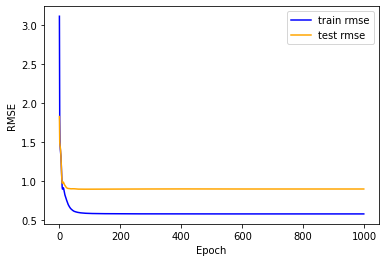

In [47]:
movies = torch.LongTensor(x_train['movieId'])
userId = torch.LongTensor(x_train['userId'])
rating = torch.FloatTensor(x_train['rating'])

movies_test = torch.LongTensor(x_test['movieId'].to_numpy())
userId_test = torch.LongTensor(x_test['userId'].to_numpy())
rating_test = torch.FloatTensor(x_test['rating'].to_numpy())

rank = 10
numMovies = movies.max() + 1
numUsers = userId.max() + 1
P = torch.rand(numMovies, rank, requires_grad=True)
Q = torch.rand(numUsers, rank, requires_grad=True)

lambda1 = 0.00001
lambda2 = 0.0004
lambda3 = 0.0001
lambda4 = 0.0002
bias_item = torch.randn(numMovies, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (rating.sum() / len(rating)).item()

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr=0.2)
X = []
Y = []
Y_test = []

for epoch in range(1000):
 hypothesis = torch.sum(P[movies] * Q[userId], dim=1) + mean + bias_item[movies] + bias_user[userId]
 #MSE = mean_squared_error(hypothesis, rating)
 RMSE = F.mse_loss(hypothesis, rating)**0.5 #np.sqrt(MSE)
 cost = RMSE
 loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)
 
 optimizer.zero_grad()
 loss.backward()
 optimizer.step()

 X.append(epoch)
 Y.append(cost)

 with torch.no_grad():
  hypo_test = torch.sum(P[movies_test] * Q[userId_test], dim=1) + mean + bias_item[movies_test] + bias_user[userId_test]
  RMSE_T = F.mse_loss(hypo_test, rating_test)**0.5
  cost_test = RMSE_T
  Y_test.append(cost_test)

 if epoch % 100 == 0:
  print("epoch: {}, cost: {}, train_rmse: {}, test_rmse: {}" .format(epoch, loss, RMSE, RMSE_T))

plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="train rmse")
plt.plot(X,Y_test, c="orange", label="test rmse")
plt.legend()
plt.show()


In [48]:
# Task 3

# meta = ratings
# meta_mv = movies ( genres set )
# meta_t = tags
# tag = (tags set)
meta_mv.movieId = pd.to_numeric(meta_mv.movieId)

meta_new = pd.merge(meta_mv, tag, on='movieId', how='inner')

def jaccard_similarity(s1, s2):
  if len(s1|s2) == 0:
    return 0
  return len(s1&s2)/len(s1|s2)

meta.movieId = pd.to_numeric(meta.movieId)
meta_r = pd.merge(meta, meta_new[['movieId', 'title']], on='movieId', how='inner')

matrix = meta_r.pivot_table(index='userId', columns='title', values='rating')

# 514번 user가 5점을 준 영화
x = meta_r[meta_r.userId == 514]
x = x[x.rating == 5.0]

from sklearn.neighbors import KNeighborsClassifier
regressor = KNeighborsClassifier(n_neighbors=20, weights="distance")
x_train = x[['userId', 'movieId', 'rating']]
y_train = meta_r[['movieId', 'rating']]
#regressor.fit(x_train, y_train)


In [50]:
# Task 3-2

def pearson_similarity(u1, u2):
  u1_c = u1-u1.mean()
  u2_c = u2-u2.mean()
  denom = np.sqrt(np.sum(u1_c**2)*np.sum(u2_c**2))
  if denom != 0:
    return np.sum(u1_c*u2_c)/denom
  else:
    return 0

def find_similar_movies (input_title, matrix, n, alpha):
    input_meta = meta_new.loc[ meta_new[ 'title'] == input_title].iloc[ 0]
    input_set = input_meta.genres | input_meta.tags
 
    result = []
 
    for this_title in matrix.columns:
        if this_title == input_title:
            continue
        this_meta = meta_new.loc[ meta_new['title'] == this_title].iloc[ 0]
        this_set = this_meta.genres | this_meta.tags
 
        pearson = pearson_similarity(matrix[this_title], matrix[input_title])
        jaccard = jaccard_similarity(this_set, input_set)

        mvid = this_meta.movieId
        score = alpha * pearson + ( 1-alpha) * jaccard
        result.append( (mvid, this_title, score) )
 
        result.sort(key= lambda r: r[2], reverse= True)
 
    return result[:n]

for i in x['title']:
  print(i)
  print(pd.DataFrame(find_similar_movies(i, matrix, 5, 0.3), columns=['movieId','title', 'score']))

Star Wars: Episode IV - A New Hope (1977)
   movieId                                              title     score
0     1210  Star Wars: Episode VI - Return of the Jedi (1983)  0.359909
1     1196  Star Wars: Episode V - The Empire Strikes Back...  0.352121
2    33493  Star Wars: Episode III - Revenge of the Sith (...  0.189717
3     1200                                      Aliens (1986)  0.178861
4    68358                                   Star Trek (2009)  0.154692
Silence of the Lambs, The (1991)
   movieId               title     score
0     4725    Session 9 (2001)  0.269751
1     8957          Saw (2004)  0.225013
2     6323     Identity (2003)  0.216713
3       22      Copycat (1995)  0.209653
4      628  Primal Fear (1996)  0.208856
Star Wars: Episode V - The Empire Strikes Back (1980)
   movieId                                              title     score
0      260          Star Wars: Episode IV - A New Hope (1977)  0.352121
1     1210  Star Wars: Episode VI - Return of the

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

meta_t['tag'].isnull().sum()
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(meta_t['tag'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def get_recommendations(idx, cosine_sim=cosine_sim):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]

    indexes = []
    for idx in movie_indices:
      print(meta_mv[meta_mv['movieId']==idx].index.values)
      indexes.append(meta_mv[meta_mv['movieId']==idx].index.values)

    print(movie_indices)
    print(indexes)
    df = pd.DataFrame(sim_scores, columns=['movieId', 'scores'])
    result = meta_mv['title'].iloc[movie_indices] 
    df['title'] = result
    return df

get_recommendations(514)


[1911]
[2058]
[2422]
[2517]
[]
[0]
[1]
[2]
[3]
[4]
[2535, 2737, 3221, 3365, 0, 1, 2, 3, 4, 5]
[array([1911]), array([2058]), array([2422]), array([2517]), array([], dtype=int64), array([0]), array([1]), array([2]), array([3]), array([4])]


,movieId,scores,title
0,2535,1.0,Toy Story (1995)
1,2737,1.0,Jumanji (1995)
2,3221,1.0,Grumpier Old Men (1995)
3,3365,1.0,Waiting to Exhale (1995)
4,0,0.0,Father of the Bride Part II (1995)
5,1,0.0,Heat (1995)
6,2,0.0,NaN
7,3,0.0,NaN
8,4,0.0,NaN
9,5,0.0,NaN


In [52]:
# Task 4

#P = torch.rand(numMovies, rank, requires_grad=True)
#meta_mv.movieId

#https://pbj0812.tistory.com/153
from sklearn.cluster import KMeans
k = 4 # 1 - 40
model = KMeans(n_clusters=k,algorithm='auto')
model.fit(x_train, P)
predict = pd.DataFrame(model.predict(x_test))
predict.columns=['predict']

r = pd.concat([x_test,predict],axis=1)
plt.scatter(r['tags'],r['genres'],c=r['predict'],alpha=0.5)

#get_recommendations(meta_new.movieId)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- timestamp
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: ignored

In [54]:

def kmeans(k, points):
  prev_assignment = []
  centroids = points[np.random.choice(points.shape[0], replace=False, size=k)]
  for epoch in range(10):
    assignment = [assign(p, centroids, k) for p in points]
    centroids = compute_centroids(assignment, points, k)
    if prev_assignment == assignment:
      break
    prev_assignment = assignment
  return assignment, centroids

def assign(point, centroids, k):
  return min(range(k), key=lambda i: np.dot(centroids[i]-point, centroids[i]-point))

def compute_centroids(assignment, points, k):
  vec_sum = [np.zeros(len(points[0])) for _ in range(k)]
  counts = [0] * k
  for i, p in zip(assignment, points):
    vec_sum[i] += p
    counts[i] += 1
  return [vec_sum[i]/counts[i] if counts[i] > 0 else random.choice(points) for i in range(k)]

################################################################################

def predict(unknown, dataset, movie_ratings, k):
  distances = []
  for title in dataset:
    movie = dataset[title]
    distances.append([distance(movie, unknown), title])
  distances.sort()	

  neighbors = distances[0:k]	
  numerator, denominator = [ 0, 0 ]

  for neighbor in neighbors:
    numerator += movie_ratings[neighbor[1]] / neighbor[0]
    denominator += 1 / neighbor[0]

  return numerator / denominator